In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn
import tensorflow as tf

In [10]:
# params and paths
path_to_train_frames=r'D:\Databases\DAiSEE\DAiSEE\train_preprocessed\extracted_faces'
path_to_train_labels=r'D:\Databases\DAiSEE\DAiSEE\Labels\TrainLabels.csv'
path_to_dev_frames=r'D:\Databases\DAiSEE\DAiSEE\dev_preprocessed\extracted_faces'
path_to_dev_labels=r'D:\Databases\DAiSEE\DAiSEE\Labels\ValidationLabels.csv'
path_to_test_frames=r'D:\Databases\DAiSEE\DAiSEE\test_preprocessed\extracted_faces'
path_to_test_labels=r'D:\Databases\DAiSEE\DAiSEE\Labels\TestLabels.csv'

In [11]:
# load labels in dataframe
train_labels=pd.read_csv(path_to_train_labels)
dev_labels=pd.read_csv(path_to_dev_labels)
test_labels=pd.read_csv(path_to_test_labels)

<font size="5">**Class distribution analysis**</font>

In [31]:
train_distribution = train_labels.drop(columns=['ClipID'])['Engagement'].value_counts()
train_distribution = train_distribution.reset_index()
train_distribution.columns= ['num_class', 'train_engagement']
dev_distribution = dev_labels.drop(columns=['ClipID'])['Engagement'].value_counts()
dev_distribution = dev_distribution.reset_index()
dev_distribution.columns= ['num_class', 'dev_engagement']
test_distribution = test_labels.drop(columns=['ClipID'])['Engagement'].value_counts()
test_distribution = test_distribution.reset_index()
test_distribution.columns= ['num_class', 'test_engagement']
all_distributions=train_distribution.merge(dev_distribution, on='num_class').merge(test_distribution, on='num_class')

<AxesSubplot:xlabel='num_class'>

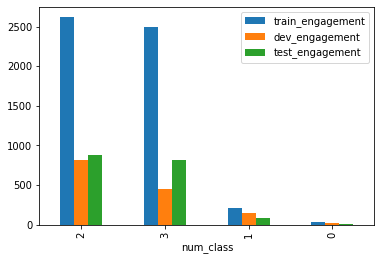

In [34]:
all_distributions.plot.bar(x='num_class')

In [41]:
train_distribution['train_engagement']=train_distribution['train_engagement']/train_distribution['train_engagement'].sum()*100
train_distribution

,num_class,train_engagement
0,2,48.842852
1,3,46.547219
2,1,3.975364
3,0,0.634565


In [43]:
dev_distribution['dev_engagement']=dev_distribution['dev_engagement']/dev_distribution['dev_engagement'].sum()*100
dev_distribution

,num_class,dev_engagement
0,2,56.892932
1,3,31.490553
2,1,10.006998
3,0,1.609517


In [44]:
test_distribution['test_engagement']=test_distribution['test_engagement']/test_distribution['test_engagement'].sum()*100
test_distribution

,num_class,test_engagement
0,2,49.439462
1,3,45.627803
2,1,4.708520
3,0,0.224215


<font size="5">**Confusion matrix for model**</font>

In [2]:
from typing import Optional, Tuple, Callable, Union
import sys
import gc
sys.path.append(r"C:\Users\Denis\PycharmProjects\datatools")
from tensorflow_utils.models.CNN_models import get_EMO_VGGFace2, _get_pretrained_VGGFace2_model
from tensorflow_utils.Layers import Non_local_block_multi_head
tf.keras.backend.clear_session()
gc.collect()

# model creation
def get_model_with_local_att(dense_neurons_after_conv: Tuple[int,...],
                                       dropout: float = 0.3,
                                       regularization:Optional[tf.keras.regularizers.Regularizer]=None,
                                       output_neurons: Union[Tuple[int,...], int] = 7, pooling_at_the_end: Optional[str] = None,
                                       pretrained: bool = True,
                                       path_to_weights: Optional[str] = None,
                                       multi_head_attention:bool=True) -> tf.keras.Model:
    pretrained_VGGFace2 = _get_pretrained_VGGFace2_model(path_to_weights, pretrained=pretrained)
    x=pretrained_VGGFace2.get_layer('activation_48').output
    if multi_head_attention:
        x = Non_local_block_multi_head(num_heads=4,  output_channels=1024,
                 head_output_channels=None,
                 downsize_factor=8,
                 shortcut_connection=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
    # take pooling or not
    if pooling_at_the_end is not None:
        if pooling_at_the_end=='avg':
            x=tf.keras.layers.GlobalAveragePooling2D()(x)
        elif pooling_at_the_end=='max':
            x=tf.keras.layers.GlobalMaxPooling2D()(x)
        else:
            raise AttributeError('Parameter pooling_at_the_end can be either \'avg\' or \'max\'. Got %s.'%(pooling_at_the_end))
    # create Dense layers
    for dense_layer_idx in range(len(dense_neurons_after_conv)-1):
        num_neurons_on_layer=dense_neurons_after_conv[dense_layer_idx]
        x = tf.keras.layers.Dense(num_neurons_on_layer, activation='relu', kernel_regularizer=regularization)(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout)(x)
    # pre-last Dense layer
    num_neurons_on_layer=dense_neurons_after_conv[-1]
    x = tf.keras.layers.Dense(num_neurons_on_layer, activation='relu')(x)
    # If outputs should be several, then create several layers, otherwise one
    if isinstance(output_neurons, tuple):
        output_layers=[]
        for num_output_neurons in output_neurons:
            if dropout:
                output_layer_i = tf.keras.layers.Dropout(dropout)(x)
            output_layer_i = tf.keras.layers.Dense(128, activation='relu')(output_layer_i)
            output_layer_i=tf.keras.layers.Dense(num_output_neurons, activation='softmax')(output_layer_i)
            #output_layer_i=tf.keras.layers.Reshape((-1, 1))(output_layer_i)
            output_layers.append(output_layer_i)
    else:
        output_layers = tf.keras.layers.Dense(output_neurons, activation='softmax')(x)
        # in tf.keras.Model it should be always a list (even when it has only 1 element)
        output_layers = [output_layers]
    # create model
    model=tf.keras.Model(inputs=pretrained_VGGFace2.inputs, outputs=output_layers)
    del pretrained_VGGFace2
    return model



model=get_model_with_local_att(dense_neurons_after_conv=(1024,),
                                               dropout=0.5,
                                               regularization=tf.keras.regularizers.l2(0.0001),
                                               output_neurons=(4,), pooling_at_the_end='avg',
                                               pretrained=True,
                                               path_to_weights=r'C:\Users\Denis\PycharmProjects\vggface2_Keras\vggface2_Keras\model\resnet50_softmax_dim512\weights.h5')

In [3]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [5]:
from sklearn.metrics import recall_score, f1_score, accuracy_score
from sklearn.utils import class_weight

from preprocessing.class_weights import get_class_weights_Effective_Number_of_Samples
from tensorflow_utils.Layers import Non_local_block_multi_head
from tensorflow_utils.keras_datagenerators.ImageDataLoader import ImageDataLoader
from tensorflow_utils.keras_datagenerators.ImageDataLoader_multilabel import ImageDataLoader_multilabel
from tensorflow_utils.keras_datagenerators.ImageDataPreprocessor import ImageDataPreprocessor
from preprocessing.data_normalizing_utils import VGGFace2_normalization
from tensorflow_utils.Losses import weighted_categorical_crossentropy, categorical_focal_loss
from tensorflow_utils.callbacks import best_weights_setter_callback, get_annealing_LRreduce_callback, validation_with_generator_callback_multilabel
from tensorflow_utils.models.CNN_models import get_modified_VGGFace2_resnet_model, _get_pretrained_VGGFace2_model
from engagementRecognition_DAiSEE import load_labels_to_dict, form_dataframe_of_relative_paths_to_data_with_multilabels
# params
path_to_test_frames = r'C:\Users\Denis\Desktop\test_preprocessed\extracted_faces'
path_to_test_labels = r'E:\Databases\DAiSEE\DAiSEE\Labels\TestLabels.csv'

input_shape = (224, 224, 3)
num_classes = 4
batch_size = 64
epochs = 30
highest_lr = 0.0005
lowest_lr = 0.00001
momentum = 0.9
weighting_beta = 0.99999
focal_loss_gamma = 2

optimizer = tf.keras.optimizers.SGD(highest_lr, momentum=momentum, clipnorm=1., decay=1e-6)
# load labels
dict_labels_test = load_labels_to_dict(path_to_test_labels)
# form dataframes with relative paths and labels
labels_test = form_dataframe_of_relative_paths_to_data_with_multilabels(path_to_test_frames, dict_labels_test)
# add full path to filename

labels_test['filename'] = path_to_test_frames + '\\' + labels_test['filename']
# convert labels into float32 type
labels_test['engagement'] = labels_test['engagement'].astype('float32')
labels_test['boredom'] = labels_test['boredom'].astype('float32')
labels_test['confusion'] = labels_test['confusion'].astype('float32')
labels_test['frustration'] = labels_test['frustration'].astype('float32')

test_gen = ImageDataLoader_multilabel(paths_with_labels=labels_test, batch_size=batch_size,
                                      class_columns=['engagement'],
                                      preprocess_function=VGGFace2_normalization,
                                      num_classes=num_classes,
                                      horizontal_flip=None, vertical_flip=None,
                                      shift=None,
                                      brightness=None, shearing=None, zooming=None,
                                      random_cropping_out=None, rotation=None,
                                      scaling=None,
                                      channel_random_noise=None, bluring=None,
                                      worse_quality=None,
                                      mixup=None,
                                      pool_workers=2)

In [6]:
import time
predictions=[]
real_labels=[]
counter=0
start=time.time()
for x,y in test_gen:
    real_labels.append(y)
    pred=model.predict(x)
    predictions.append(pred)
    del x
    gc.collect()
    if counter%10==0:
        print(time.time()-start, test_gen.__len__(), counter)
        start=time.time()
    counter+=1

12.734514713287354 1676 0
8.443964958190918 1676 10
8.565596342086792 1676 20
8.427371978759766 1676 30
8.640825510025024 1676 40
9.235960960388184 1676 50
8.856686115264893 1676 60
8.624325037002563 1676 70
8.6351900100708 1676 80
8.694414615631104 1676 90
8.540807485580444 1676 100
8.613829612731934 1676 110
8.622787952423096 1676 120
8.619218111038208 1676 130
8.644325494766235 1676 140
8.62363862991333 1676 150
8.54887080192566 1676 160
8.599847793579102 1676 170
8.565728425979614 1676 180
8.654712438583374 1676 190
8.499471426010132 1676 200
8.654106616973877 1676 210
9.705556631088257 1676 220
8.55079197883606 1676 230
8.602932929992676 1676 240
8.610795259475708 1676 250
8.622027397155762 1676 260
8.542712450027466 1676 270
8.653512477874756 1676 280
8.588158369064331 1676 290
8.604227304458618 1676 300
8.636564254760742 1676 310
8.61597490310669 1676 320
8.699685096740723 1676 330
9.266079902648926 1676 340
12.393597602844238 1676 350
9.50697660446167 1676 360
9.332867860794067

In [24]:
ground_truth=np.concatenate([np.array(item).squeeze() for item in real_labels], axis=0)

In [25]:
pred=np.concatenate([np.array(item).squeeze() for item in predictions], axis=0)

In [30]:
np.unique(pred.argmax(axis=-1), return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([12767, 50874, 30621, 12968], dtype=int64))

In [31]:
np.unique(ground_truth.argmax(axis=-1), return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([  240,  5030, 52982, 48978], dtype=int64))

In [33]:
import sklearn
sklearn.metrics.confusion_matrix(ground_truth.argmax(axis=-1), pred.argmax(axis=-1))

array([[   11,   162,     2,    65],
       [  712,  2363,  1042,   913],
       [ 5694, 26182, 14504,  6602],
       [ 6350, 22167, 15073,  5388]], dtype=int64)